**What is actually fraud and unusual behaviour? Are both always relate to each other?**


*Fraud is generally defined in the law as an intentional misrepresentation of material existing fact
made by one person to another with knowledge of its falsity and for the purpose of inducing the other
person to act, and upon which the other person relies with resulting injury or damage. Fraud may also
be made by an omission or purposeful failure to state material facts, which nondisclosure makes other
statements misleading.*


*Unusual behavior is a behavior, which is somehow different from the other individuals. Unusual
doesn’t have to mean fraudulent, for example when one employee is high performer or low performer.*

*We will try to more relate and find relationship between them.*

[Reference](http://si-journal.org/index.php/JSI/article/viewFile/173/130)

In [ ]:
import time

x = time.time()

import pandas as pd
import numpy  as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()

import warnings
warnings.filterwarnings("ignore")



#FRAUD DETECTION

**These are all columns descriptions from INSAID DATA DICTIONARY**

* step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

* type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

* amount - amount of the transaction in local currency.

* nameOrig - customer who started the transaction

* oldbalanceOrg - initial balance before the transaction

* newbalanceOrig - new balance after the transaction

* nameDest - customer who is the recipient of the transaction

* oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

* newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

* isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control of customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

* isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [ ]:
data_file = "/content/drive/MyDrive/Copy of Fraud.csv"
datasets =pd.read_csv(data_file)

In [ ]:
datasets.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Columns: 11 entries, step to isFlaggedFraud
dtypes: float64(5), int64(3), object(3)
memory usage: 1.6 GB


In [ ]:
datasets.head(20)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [ ]:
# credit to unknown guy from internet for the memory reduction 
# It is not hard to implement but it could be good idea for millions rows data
# I have done similar to this but only for one or two columns to solve a doubt question
def memory_usage_mb(df, *args, **kwargs):
    """Dataframe memory usage in MB. """
    return df.memory_usage(*args, **kwargs).sum() / 1024**2

def reduce_memory_usage(df, deep=True, verbose=True):
    # All types that we want to change for "lighter" ones.
    # int8 and float16 are not include because we cannot reduce
    # those data types.
    # float32 is not include because float16 has too low precision.
    numeric2reduce = ["int16", "int32", "int64", "float64"]
    start_mem = 0
    if verbose:
        start_mem = memory_usage_mb(df, deep=deep)

    for col, col_type in df.dtypes.iteritems():
        best_type = None
        if col_type in numeric2reduce:
            downcast = "integer" if "int" in str(col_type) else "float"
            df[col] = pd.to_numeric(df[col], downcast=downcast)
            best_type = df[col].dtype.name
        # Log the conversion performed.
        if verbose and best_type is not None and best_type != str(col_type):
            print(f"Column '{col}' converted from {col_type} to {best_type}")

    if verbose:
        end_mem = memory_usage_mb(df, deep=deep)
        diff_mem = start_mem - end_mem
        percent_mem = 100 * diff_mem / start_mem
        print(f"Memory usage decreased from"
              f" {start_mem:.2f}MB to {end_mem:.2f}MB"
              f" ({diff_mem:.2f}MB, {percent_mem:.2f}% reduction)")
        
    return df

datasets = reduce_memory_usage(datasets)

Column 'step' converted from int64 to int16
Column 'amount' converted from float64 to float32
Column 'oldbalanceOrg' converted from float64 to float32
Column 'newbalanceOrig' converted from float64 to float32
Column 'oldbalanceDest' converted from float64 to float32
Column 'newbalanceDest' converted from float64 to float32
Column 'isFraud' converted from int64 to int8
Column 'isFlaggedFraud' converted from int64 to int8
Memory usage decreased from 1598.19MB to 1355.48MB (242.71MB, 15.19% reduction)


In [ ]:
columns = datasets.columns
column_nan_count = {}
for col in columns:
    try:
        nan_count = np.isnan(datasets[col]).value_counts()
        if True in nan_count.index:
            column_nan_count[col]= nan_count[0]
    except TypeError:
        pass
if not column_nan_count:
    print(f"There are no nan values in dataFrame\n{column_nan_count}") 
else:       
    print("Given nan value count of column wise in dictionary",column_nan_count)

There are no nan values in dataFrame
{}


In [ ]:
datasets['isFraud']

0          0
1          0
2          1
3          1
4          0
          ..
6362615    1
6362616    1
6362617    1
6362618    1
6362619    1
Name: isFraud, Length: 6362620, dtype: int8

In [ ]:
# fig, ax = plt.subplots(figsize= (6, 12))
# sns.relplot(x =datasets['isFraud'], y = datasets['isFlaggedFraud'], data = datasets, ax = ax)

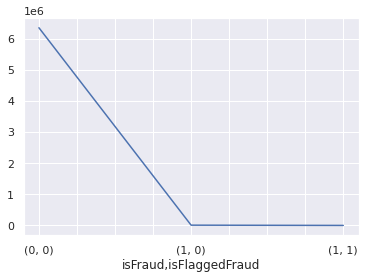

In [ ]:
data_group_fraud = datasets.groupby(['isFraud','isFlaggedFraud']).count()
(data_group_fraud['step']).plot()

In [ ]:
s = data_group_fraud['step'].sum()
data = round((data_group_fraud/s)*100, 5)

"""
Buisness model is very successfull in detecting ok transaction. But it is bias over declering a transaction ok, perhaps due to customer support.
"""

'\nBuisness model is very successfull in detecting ok transaction. But it is bias over declering a transaction ok, perhaps due to customer support.\n'

In [ ]:
datasets.head(3)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.639648,C1231006815,170136.0,160296.359375,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.280029,C1666544295,21249.0,19384.720703,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.000000,C1305486145,181.0,0.000000,C553264065,0.0,0.0,1,0


**Old balance from origin and new balance of destination**

Both have linear distribution. 



Text(0, 0.5, 'newbalanceOrig')

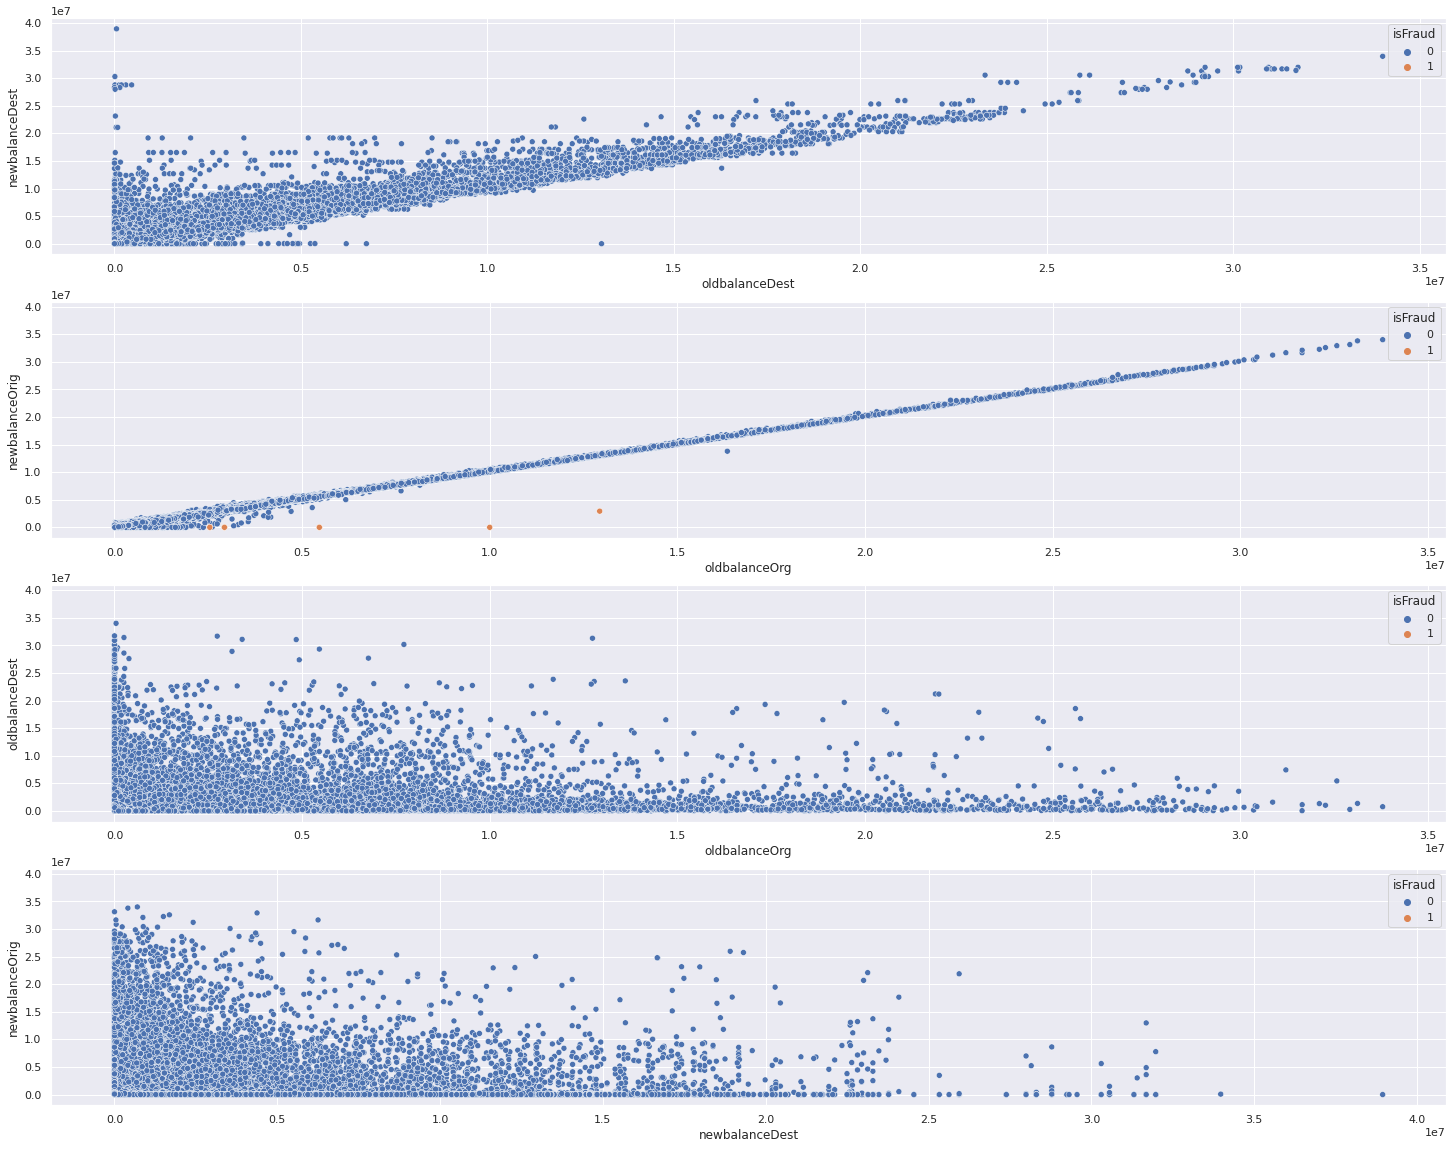

In [ ]:
fig, ax = plt.subplots(4, 1,sharey=True,figsize= (25, 20))

sns.scatterplot(x = datasets['oldbalanceDest'][:100_000], y=datasets['newbalanceDest'][:100_000], hue=datasets['isFraud'][:100_000], data=datasets[:100_000],ax=ax[0])
ax[0].set_xlabel('oldbalanceDest'); ax[0].set_ylabel('newbalanceDest')

sns.scatterplot(x = datasets['oldbalanceOrg'][:100_000], y=datasets['newbalanceOrig'][:100_000], hue=datasets['isFraud'][:100_000], data=datasets[:100_000],ax=ax[1])
ax[1].set_xlabel('oldbalanceOrg'); ax[1].set_ylabel('newbalanceOrig')


sns.scatterplot(x = datasets['oldbalanceOrg'][:100_000], y=datasets['oldbalanceDest'][:100_000], hue=datasets['isFraud'][:100_000], data=datasets[:100_000],ax=ax[2])
ax[2].set_xlabel('oldbalanceOrg'); ax[2].set_ylabel('oldbalanceDest')

sns.scatterplot(x = datasets['newbalanceDest'][:100_000], y=datasets['newbalanceOrig'][:100_000], hue=datasets['isFraud'][:100_000], data=datasets[:100_000],ax=ax[3])
ax[3].set_xlabel('newbalanceDest'); ax[3].set_ylabel('newbalanceOrig')



In [ ]:
fig.savefig("balance_figure.png")



In [ ]:
def get_validation_data(data, split=0.2):
    X_train, X_test, y_train, y_test = train_test_split(data, test_split= split)
    return X_train, X_test, y_train, y_test

In [ ]:
identity_data_columns = datasets.columns
numericCols = datasets._get_numeric_data().columns
categoricalCols = list(set(identity_data_columns) - set(numericCols))
print('The categorical columns in identity data are: ',categoricalCols)
print('The numerical columns in identity data are: ',list(numericCols))


The categorical columns in identity data are:  ['nameOrig', 'nameDest', 'type']
The numerical columns in identity data are:  ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']


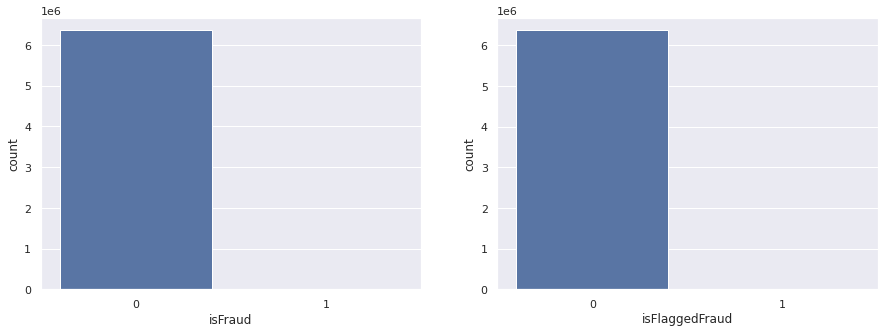

In [ ]:
fig, ax = plt.subplots(1,2, figsize= (15,5))

sns.countplot(datasets['isFraud'], ax=ax[0], )
sns.countplot(datasets['isFlaggedFraud'], ax=ax[1])


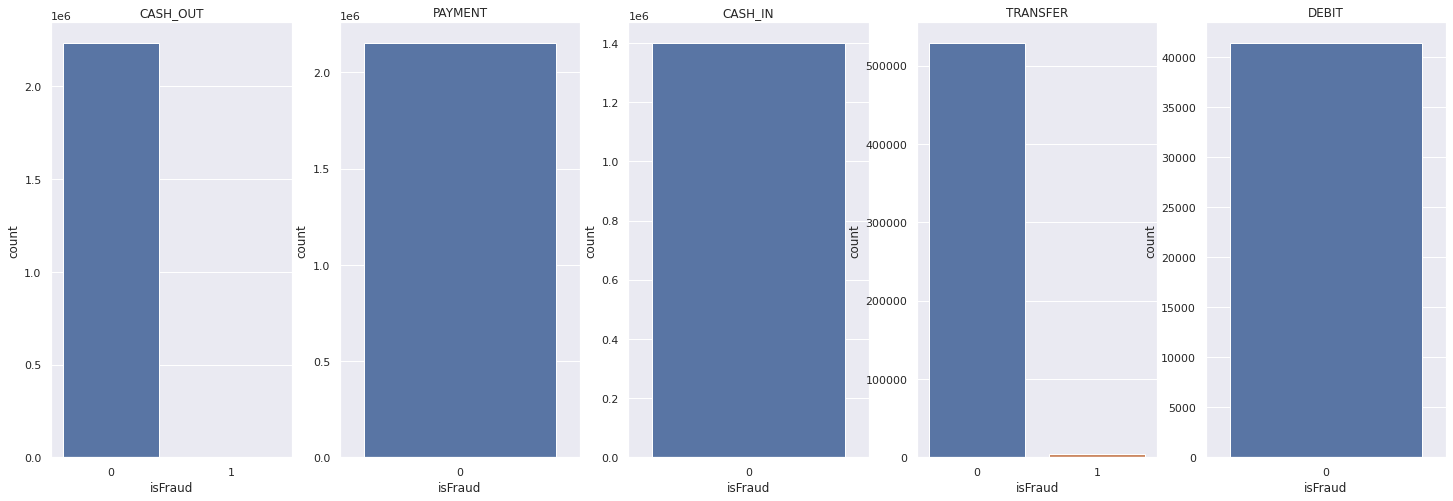

In [ ]:
cardTypes = list(datasets['type'].value_counts().index)
fig, ax = plt.subplots(1,len(cardTypes), figsize= (25,8))


for i,i_card in enumerate(cardTypes):
    cardData = eval('datasets.loc[datasets["type"]=="'+i_card+'"]')
    # plt.figure(i)
    sns.countplot(cardData['isFraud'],ax=ax[i]).set_title(i_card)

In [ ]:
datasets.head(20)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.639648,C1231006815,170136.000000,160296.359375,M1979787155,0.0,0.000000,0,0
1,1,PAYMENT,1864.280029,C1666544295,21249.000000,19384.720703,M2044282225,0.0,0.000000,0,0
2,1,TRANSFER,181.000000,C1305486145,181.000000,0.000000,C553264065,0.0,0.000000,1,0
3,1,CASH_OUT,181.000000,C840083671,181.000000,0.000000,C38997010,21182.0,0.000000,1,0
4,1,PAYMENT,11668.139648,C2048537720,41554.000000,29885.859375,M1230701703,0.0,0.000000,0,0
5,1,PAYMENT,7817.709961,C90045638,53860.000000,46042.289062,M573487274,0.0,0.000000,0,0
6,1,PAYMENT,7107.770020,C154988899,183195.000000,176087.234375,M408069119,0.0,0.000000,0,0
7,1,PAYMENT,7861.640137,C1912850431,176087.234375,168225.593750,M633326333,0.0,0.000000,0,0
8,1,PAYMENT,4024.360107,C1265012928,2671.000000,0.000000,M1176932104,0.0,0.000000,0,0
9,1,DEBIT,5337.770020,C712410124,41720.000000,36382.230469,C195600860,41898.0,40348.789062,0,0


In [ ]:
print('The average transaction amount for non fraudulent transactions is: ', 
      np.mean(datasets.loc[datasets["isFraud"]==0]['amount']))
print('The average transaction amount for fraudulent transactions is: ', 
      np.mean(datasets.loc[datasets["isFraud"]==1]['amount']))

print("\n")

print('The maximum transaction amount for non fraudulent transactions is: ', 
      np.max(datasets.loc[datasets["isFraud"]==0]['amount']))
print('The maximum transaction amount for fraudulent transactions is: ', 
      np.max(datasets.loc[datasets["isFraud"]==1]['amount']))

print("\n")

print('The minimum transaction amount for non fraudulent transactions is: ', 
      np.min(datasets.loc[datasets["isFraud"]==0]['amount']))
print('The minimum transaction amount for fraudulent transactions is: ', 
      np.min(datasets.loc[datasets["isFraud"]==1]['amount']))

print("\n")

maxTypeData = {}
minTypeData = {}
meanTypeData = {}
for i,i_card in enumerate(cardTypes):
    cardData = eval('datasets.loc[datasets["type"]=="'+i_card+'"]')
    maxTypeData[i_card] = np.max(cardData['amount'])
    minTypeData[i_card] = np.min(cardData['amount'])
    meanTypeData[i_card] = np.mean(cardData['amount'])


print("\n")

print('The maximum transactions by card are:', maxTypeData)
print('The minimum transactions by card are:', minTypeData)
print('The average transactions by card are:', meanTypeData)

The average transaction amount for non fraudulent transactions is:  176346.03125
The average transaction amount for fraudulent transactions is:  1467973.375


The maximum transaction amount for non fraudulent transactions is:  92445520.0
The maximum transaction amount for fraudulent transactions is:  10000000.0


The minimum transaction amount for non fraudulent transactions is:  0.009999999776482582
The minimum transaction amount for fraudulent transactions is:  0.0




The maximum transactions by card are: {'CASH_OUT': 10000000.0, 'PAYMENT': 238637.984375, 'CASH_IN': 1915267.875, 'TRANSFER': 92445520.0, 'DEBIT': 569077.5}
The minimum transactions by card are: {'CASH_OUT': 0.0, 'PAYMENT': 0.019999999552965164, 'CASH_IN': 0.03999999910593033, 'TRANSFER': 2.5999999046325684, 'DEBIT': 0.550000011920929}
The average transactions by card are: {'CASH_OUT': 176219.21875, 'PAYMENT': 13053.775390625, 'CASH_IN': 168904.28125, 'TRANSFER': 910590.875, 'DEBIT': 5483.6494140625}


In [ ]:
from sklearn.model_selection import StratifiedKFold,GroupKFold
from sklearn.metrics import roc_curve, auc
from lightgbm import LGBMClassifier
import lightgbm as lgb

#group_kfold = GroupKFold(n_splits=5)
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

In [ ]:
def compute_roc_auc(clf,index):
    y_predict = clf.predict_proba(train_data.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(target_data.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

In [ ]:
datasets

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9.839640e+03,C1231006815,170136.000,160296.359375,M1979787155,0.000000e+00,0.000,0,0
1,1,PAYMENT,1.864280e+03,C1666544295,21249.000,19384.720703,M2044282225,0.000000e+00,0.000,0,0
2,1,TRANSFER,1.810000e+02,C1305486145,181.000,0.000000,C553264065,0.000000e+00,0.000,1,0
3,1,CASH_OUT,1.810000e+02,C840083671,181.000,0.000000,C38997010,2.118200e+04,0.000,1,0
4,1,PAYMENT,1.166814e+04,C2048537720,41554.000,29885.859375,M1230701703,0.000000e+00,0.000,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,3.396821e+05,C786484425,339682.125,0.000000,C776919290,0.000000e+00,339682.125,1,0
6362616,743,TRANSFER,6.311410e+06,C1529008245,6311409.500,0.000000,C1881841831,0.000000e+00,0.000,1,0
6362617,743,CASH_OUT,6.311410e+06,C1162922333,6311409.500,0.000000,C1365125890,6.848884e+04,6379898.000,1,0
6362618,743,TRANSFER,8.500025e+05,C1685995037,850002.500,0.000000,C2080388513,0.000000e+00,0.000,1,0


In [ ]:
split_size = int(datasets[numericCols].shape[0]*0.80)

train_df, test_data = datasets[numericCols].iloc[:split_size,:], datasets[numericCols].iloc[split_size:,:-2]

test_data_target = datasets[numericCols].iloc[split_size:,-2]
train_data = train_df.iloc[:,:-2]; target_data = train_df.iloc[:,-2]

test_data.drop(axis=1, columns='isFlaggedFraud',inplace=True, errors='ignore')


#Estimators and models (LightGBM, sklearn feature selection, decision tree, svm)

In [ ]:
!pip install bayesian-optimization


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_data, target_data, test_size=0.25, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3817572, 6), (1272524, 6), (3817572,), (1272524,))

In [ ]:
# Bounded region of parameter space
bounds_LGB = {
    'num_leaves': (31, 500), 
    'min_data_in_leaf': (20, 200),
    'bagging_fraction' : (0.1, 0.9),
    'feature_fraction' : (0.1, 0.9),
    'learning_rate': (0.01, 0.3),
    'min_child_weight': (1, 4),   
    'reg_alpha': (0.2,2), 
    'reg_lambda': (0.2,2),
    'max_depth':(-1,50),
    'n_estimators':(750,7500),
    'max_bin':(32,256)
}

# bayes_opt, it is used for choosing best parameters, it is optimized algorithm for parameters tuning
"""
Bayesian optimization works by constructing a posterior distribution of functions (gaussian process) that best describes 
the function you want to optimize. As the number of observations grows, the posterior distribution improves, and the algorithm 
becomes more certain of which regions in parameter space are worth exploring and which are not.

Credit
Please see also https://github.com/fmfn/BayesianOptimization
"""
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data, target_data, test_size=0.25, random_state=42)
train_index = X_train.index
test_index = X_test.index

# Learn from LGB official docs and some tricks from internet blogs
def LGB_bayesian(num_leaves,bagging_fraction,feature_fraction,min_child_weight,
                 min_data_in_leaf,max_depth,n_estimators,reg_alpha,reg_lambda,learning_rate,max_bin):
    num_leaves = int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
    min_child_weight = int(min_child_weight)
    max_bin = int(max_bin)

    assert type(num_leaves) == int
    assert type(min_data_in_leaf) == int
    assert type(max_depth) == int
    assert type(n_estimators) == int
    assert type(min_child_weight) == int
    assert type(max_bin) == int
    param = {'num_leaves': num_leaves,'min_data_in_leaf': min_data_in_leaf,'min_child_weight': min_child_weight,'bagging_fraction' : bagging_fraction,
             'feature_fraction' : feature_fraction,'max_depth': max_depth,'reg_alpha': reg_alpha,'reg_lambda': reg_lambda,
              'objective': 'binary','boosting_type': 'gbdt','colsample_bytree':.8,'subsample':.9,'min_split_gain':.01,'max_bin':max_bin,
             'bagging_freq':5,'learning_rate':learning_rate,'metric':'auc','n_estimators':n_estimators,'min_data_in_leaf':min_data_in_leaf,
            'early_stopping_rounds':5} 
    lgb_bayes = LGBMClassifier(boosting = param['boosting_type'],n_estimators =  param['n_estimators'],
                     learning_rate =  param['learning_rate'],num_leaves =  param['num_leaves'],
                     colsample_bytree = param['colsample_bytree'],subsample =  param['subsample'],
                     max_depth =  param['max_depth'],reg_alpha =  param['reg_alpha'],
                     reg_lambda =  param['reg_lambda'],min_split_gain =  param['min_split_gain'],
                     min_child_weight =  param['min_child_weight'],max_bin =  param['max_bin'],
                     bagging_freq =  param['bagging_freq'],feature_fraction =  param['feature_fraction'],
                     bagging_fraction =  param['bagging_fraction'],min_data_in_leaf = param['min_data_in_leaf'],
                              early_stopping_rounds = param['early_stopping_rounds'])
    lgb_bayes.fit(train_data.iloc[train_index,:], target_data.iloc[train_index],
                 eval_set = [(train_data.iloc[train_index,:], target_data.iloc[train_index]), 
                             (train_data.iloc[test_index,:], target_data.iloc[test_index])],eval_metric='auc',verbose = 200)
    fpr, tpr, auc_score = compute_roc_auc(lgb_bayes,test_index)  
    return auc_score
lightGBM_bo = BayesianOptimization(LGB_bayesian, bounds_LGB, random_state=42)
print(lightGBM_bo.space.keys)
init_points = 10
n_iter = 35
print('-' * 130)

lightGBM_bo.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)
print(lightGBM_bo.max['target'])
print(lightGBM_bo.max['params'])
params = {
        'n_estimators': int(lightGBM_bo.max['params']['n_estimators']), 
        'num_leaves': int(lightGBM_bo.max['params']['num_leaves']), 
        'min_child_weight': lightGBM_bo.max['params']['min_child_weight'],
        'min_data_in_leaf': int(lightGBM_bo.max['params']['min_data_in_leaf']),
        'bagging_fraction': lightGBM_bo.max['params']['bagging_fraction'], 
        'feature_fraction': lightGBM_bo.max['params']['feature_fraction'],
        'reg_lambda': lightGBM_bo.max['params']['reg_lambda'],
        'reg_alpha': lightGBM_bo.max['params']['reg_alpha'],
        'max_depth': int(lightGBM_bo.max['params']['max_depth']), 
        'metric':'auc',
        'boosting_type': 'gbdt',
        'colsample_bytree':.8,'subsample':.9,
        'min_split_gain':.01,
        'max_bin':int(lightGBM_bo.max['params']['max_bin']), #127,
        'bagging_freq':5,
        'learning_rate':lightGBM_bo.max['params']['learning_rate'],
        #'learning_rate':0.01,
        'early_stopping_rounds':10
    }

In [ ]:
params = {
        'n_estimators': int(lightGBM_bo.max['params']['n_estimators']), 
        'num_leaves': int(lightGBM_bo.max['params']['num_leaves']), 
        'min_child_weight': lightGBM_bo.max['params']['min_child_weight'],
        'min_data_in_leaf': int(lightGBM_bo.max['params']['min_data_in_leaf']),
        'bagging_fraction': lightGBM_bo.max['params']['bagging_fraction'], 
        'feature_fraction': lightGBM_bo.max['params']['feature_fraction'],
        'reg_lambda': lightGBM_bo.max['params']['reg_lambda'],
        'reg_alpha': lightGBM_bo.max['params']['reg_alpha'],
        'max_depth': int(lightGBM_bo.max['params']['max_depth']), 
        'metric':'auc',
        'boosting_type': 'gbdt',
        'colsample_bytree':.8,'subsample':.9,
        'min_split_gain':.01,
        'max_bin':int(lightGBM_bo.max['params']['max_bin']), #127,
        'bagging_freq':5,
        'learning_rate':lightGBM_bo.max['params']['learning_rate'],
        #'learning_rate':0.01,
        'early_stopping_rounds':10
    }

# output
params = {'bagging_fraction': 0.7476577318249625,
            'bagging_freq': 5,
            'boosting_type': 'gbdt',
            'colsample_bytree': 0.8,
            'early_stopping_rounds': 10,
            'feature_fraction': 0.3633517664675696,
            'learning_rate': 0.19814417499324963,
            'max_bin': 237,
            'max_depth': 13,
            'metric': 'auc',
            'min_child_weight': 1.2341367618017487,
            'min_data_in_leaf': 179,
            'min_split_gain': 0.01,
            'n_estimators': 777,
            'num_leaves': 54,
            'reg_alpha': 0.54539945273589,
            'reg_lambda': 1.2261422129395818,
            'subsample': 0.9
 }

{'bagging_fraction': 0.7476577318249625,
 'bagging_freq': 5,
 'boosting_type': 'gbdt',
 'colsample_bytree': 0.8,
 'early_stopping_rounds': 10,
 'feature_fraction': 0.3633517664675696,
 'learning_rate': 0.19814417499324963,
 'max_bin': 237,
 'max_depth': 13,
 'metric': 'auc',
 'min_child_weight': 1.2341367618017487,
 'min_data_in_leaf': 179,
 'min_split_gain': 0.01,
 'n_estimators': 777,
 'num_leaves': 54,
 'reg_alpha': 0.54539945273589,
 'reg_lambda': 1.2261422129395818,
 'subsample': 0.9}

In [ ]:
X_test.shape, X_train.shape

((1272524, 6), (3817572, 6))

In [ ]:
fprs_lgb, tprs_lgb, scores_lgb = [], [], []
feature_importances = pd.DataFrame()
feature_importances['feature'] = train_data.columns     
predictions = np.zeros(len(test_data))
for (train, test), i in zip(cv.split(train_data, target_data), range(5)):
    lgb_best = LGBMClassifier(boosting = params['boosting_type'],n_estimators =  params['n_estimators'],
                     learning_rate =  params['learning_rate'],num_leaves =  params['num_leaves'],
                     colsample_bytree = params['colsample_bytree'],subsample =  params['subsample'],
                     max_depth =  params['max_depth'],reg_alpha =  params['reg_alpha'],
                     reg_lambda =  params['reg_lambda'],min_split_gain =  params['min_split_gain'],
                     min_child_weight =  params['min_child_weight'],max_bin =  params['max_bin'],
                     bagging_freq =  params['bagging_freq'],feature_fraction =  params['feature_fraction'],
                     bagging_fraction =  params['bagging_fraction'],min_data_in_leaf = params['min_data_in_leaf'],
                             early_stopping_rounds = params['early_stopping_rounds'])
    lgb_best.fit(train_data.iloc[train,:], target_data.iloc[train],
                 eval_set = [(train_data.iloc[train,:], target_data.iloc[train]), 
                             (train_data.iloc[test,:], target_data.iloc[test])],eval_metric='auc',verbose = 200)    
    feature_importances['fold_{}'.format(i + 1)] = lgb_best.feature_importances_
    _, _, auc_score_train = compute_roc_auc(lgb_best,train)
    fpr, tpr, auc_score = compute_roc_auc(lgb_best,test)
    scores_lgb.append((auc_score_train, auc_score))
    fprs_lgb.append(fpr)
    tprs_lgb.append(tpr) 
    predictions += lgb_best.predict_proba(test_data, num_iteration=lgb_best.best_iteration_)[:,1]

Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[82]	valid_0's binary_logloss: 0.000735501	valid_0's auc: 0.999027	valid_1's binary_logloss: 0.000975762	valid_1's auc: 0.997439
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[82]	valid_0's binary_logloss: 0.000745537	valid_0's auc: 0.998796	valid_1's binary_logloss: 0.000989012	valid_1's auc: 0.997157
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.000771095	valid_0's auc: 0.998125	valid_1's binary_logloss: 0.000937603	valid_1's auc: 0.997624
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.0103315	valid_0's auc: 0.950417	valid_1's binary_logloss: 0.00982224	valid_1's auc: 0.952433
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[83

In [ ]:
test_prediction = lgb_best.predict(test_data,num_iteration=lgb_best.best_iteration_)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print(f'Mean Absolute Error\t{mean_absolute_error(test_data_target, test_prediction)}')
print(f'Mean Squared Error\t{mean_squared_error(test_data_target, test_prediction)}')


Mean Absolute Error	0.0014970248105340253
Mean Squared Error	0.0014970248105340253


In [ ]:
test_data.shape, train_data.shape

((1272524, 7), (5090096, 6))

In [ ]:
predictions /= cv.n_splits

In [ ]:
predictions[0], test_data.shape

(2.1944775280862036e-05, (1272524, 6))

In [ ]:
tprs_lgb

[array([0.        , 0.00252525, 0.00757576, ..., 1.        , 1.        ,
        1.        ]),
 array([0.        , 0.00126422, 0.00379267, ..., 1.        , 1.        ,
        1.        ]),
 array([0.        , 0.00252525, 0.00378788, ..., 1.        , 1.        ,
        1.        ]),
 array([0.        , 0.01767677, 0.02020202, ..., 1.        , 1.        ,
        1.        ]),
 array([0.        , 0.00126263, 0.00631313, ..., 1.        , 1.        ,
        1.        ])]

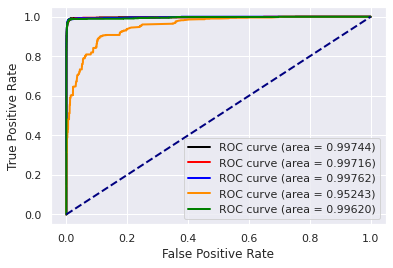

In [ ]:
def plot_roc(fprs_lgb, tprs_lgb):
    plt.figure()
    lw = 2
    colors = ['black','red','blue','darkorange','green']
    for i in range(0,5):
        plt.plot(fprs_lgb[i], tprs_lgb[i], color=colors[i],
                lw=lw, label='ROC curve (area = %0.5f)' % scores_lgb[i][1])
        
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
scores_lgb
print('Mean AUC:', np.mean(scores_lgb,axis = 0))

Mean AUC: [0.98896028 0.98817074]


In [ ]:
print((time.time()-x)/60, "minutes")

100.77058955828349 minutes


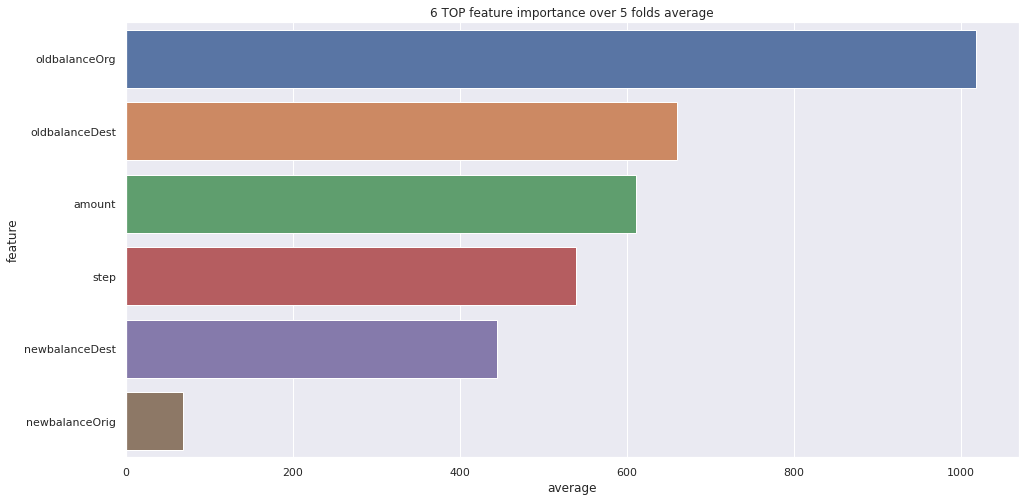

In [ ]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(cv.n_splits)]].mean(axis=1)
plt.figure(figsize=(16, 8))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('6 TOP feature importance over {} folds average'.format(cv.n_splits));

In [ ]:
train_data2 = datasets
X_train, X_test, y_train, y_test = train_test_split(train_data, target_data, test_size=0.25, random_state=42)
train_index = X_train.index
test_index = X_test.index


lgb_best_cat = LGBMClassifier(boosting = params['boosting_type'],n_estimators =  params['n_estimators'],
                     learning_rate =  params['learning_rate'],num_leaves =  params['num_leaves'],
                     colsample_bytree = params['colsample_bytree'],subsample =  params['subsample'],
                     max_depth =  params['max_depth'],reg_alpha =  params['reg_alpha'],
                     reg_lambda =  params['reg_lambda'],min_split_gain =  params['min_split_gain'],
                     min_child_weight =  params['min_child_weight'],max_bin =  params['max_bin'],
                     bagging_freq =  params['bagging_freq'],feature_fraction =  params['feature_fraction'],
                     bagging_fraction =  params['bagging_fraction'],min_data_in_leaf = params['min_data_in_leaf'],
                             early_stopping_rounds = params['early_stopping_rounds'], categorical_feature= True)


lgb_best.fit(train_data.iloc[train,:], target_data.iloc[train],
                 eval_set = [(train_data.iloc[train,:], target_data.iloc[train]), 
                             (train_data.iloc[test,:], target_data.iloc[test])],eval_metric='auc',verbose = 200)    
    

###DecisionTreeClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

x = time.time()
tree_clf = DecisionTreeClassifier(
    criterion='gini', splitter='best', max_depth=params['max_depth'], min_samples_split=2, min_samples_leaf=params['num_leaves'],
 min_weight_fraction_leaf=0.0, max_features=None, random_state=41, 
max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort='deprecated',
 ccp_alpha=0.0
)


tree_clf.fit(X_train, y_train)

y_pred = tree_clf.predict(X_test)
print("mean squared error\t",mean_squared_error(y_pred, y_test) )

fpr, tpr, auc_score = compute_roc_auc(tree_clf,test_index)  

print("Total running time of model (in minutes)\t",(time.time()-x)/60)

mean squared error	 0.00035362790800016347
Total running time of model (in minutes)	 0.7829866568247478


###SVM

In [ ]:
# This is very slow , required restart of notebook

###VarianceThreshold

VarianceThreshold is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e. features that have the same value in all samples.

As an example, suppose that we have a dataset with boolean features, and we want to remove all features that are either one or zero (on or off) in more than 80% of the samples. Boolean features are Bernoulli random variables, and the variance of such variables is given by

V(x) = p(1-p)


so we can select using the threshold .8 * (1 - .8):

In [ ]:
from sklearn.feature_selection import VarianceThreshold


sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
feature_X = sel.fit_transform(X_train)


In [ ]:
feature_X.shape

(3817572, 6)

#Asked Questions

**1. Data cleaning including missing values, outliers and multi-collinearity.**

What we do with missing values depends on data size of nan value count and how important other entries of row could be for our analysis, it could be checked by distibution of data. 
* Remove row or Replace nan values by mean\mode\median if more than half number of columns in row are nan, else remove column or do replace nan

**Outliers**
These points are clearly visible if we plot it properly, most of times, removal is best option or replace them with max value or normalize them with minimum value. 


```
Q3 = datasets.loc['75%']; Q1 = datasets.loc['25%']
IQR = Q3 - Q1

upper_iqr = Q3 +1.5*IQR
lower_iqr  = Q1 - 1.5*IQR

Condition for outliers is datasets['target']<=  upper_iqr and df['target']<= lower_iqr
```

**Multi-collinearity**

* Multicollinearity is a statistical concept where independent variables in a model are correlated.
* Multicollinearity among independent variables will result in less reliable statistical inferences.
* It is better to use independent variables that are not correlated or repetitive when building multiple regression models that use two or more variables.


**2. Describe your fraud detection model in elaboration.**

There is not much data cleaning involve here as there are  not single nan value present in data. 
So I did most of ploting of data (it took lot time as data size is in millions). I used LightGBM Python package, it is gradient boosting algorithm for classifcation and features selection (also for regression). 

While other algorithms trees grow horizontally, LightGBM algorithm grows vertically meaning it grows leaf-wise and other algorithms grow level-wise. LightGBM chooses the leaf with large loss to grow. It can lower down more loss than a level wise algorithm when growing the same leaf.

 

3. How did you select variables to be included in the model?

I do not know much about advanced techniques. I simply excluded Id's and some non-useful variables which are usually identities of rows.

But we can use the Light GBM model for feature selection. And Sklearn VarianceThreshold class for removing low variance features.


4. Demonstrate the performance of the model by using the best set of tools.

I have sklearn metrics and library model metrics. 
I  used most of the time Root mean square, F test, Precision-Recall and ROC curve metrics. 


5. What are the key factors that predict fraudulent customers?

I have provided the above graph for this question.

6. Do these factors make sense? If yes, How? If not, How not?

Yes, It is based on the mean average score prediction


7. What kind of prevention should be adopted while the company update its infrastructure?

Additional security measures could be implemented for unusual transactions. 


8. Assuming these actions have been implemented, how would you determine if they work?

Online learning could be implemented. There are lots of data generated every minute for the transaction. Machine prediction with expert filtering may help in detecting real-time fraud.

We can build a dashboard for various accuracy and metrics, automation is not hard for this, and prediction for small chunks after big data training.
Deep learning and boosting algorithm are great for this kind of work.

Thank You 

Sourabh Sahu